In [2]:
%run 02_backtesting_environment.ipynb
import numpy as np
import pandas as pd
import importlib
from scipy.special import expit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import config
from datetime import datetime, timedelta
importlib.reload(config)

import warnings
# Suppress all warnings (not recommended unless you're sure)
warnings.filterwarnings("ignore")

In [3]:
#sigmoid function
def sigmoid2(x):
    return_value = np.where(x>=0, 1 / (1 + np.exp(-x)),0)
    return return_value

def sigmoid(x): 
    return expit(x)

#derivative of sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

#setting random weights at first
def initialize_weights(input_size, hidden_size, output_size):
    np.random.seed(42)
    #randomly initialize weights for the connection between input layer and hidden layers
    weights_input_hidden = 2 * np.random.random((input_size, hidden_size)) - 1
    #randomly initialize weights for the connection between hidden layers and output layer
    weights_hidden_output = 2 * np.random.random((hidden_size, output_size)) - 1
    return weights_input_hidden, weights_hidden_output

#one "step" in the neural network:
def neural_network(inputs, weights_input_hidden, weights_hidden_output):
    #transform input values with the weights to hidden layer values
    hidden_layer_output = sigmoid(np.dot(inputs, weights_input_hidden))
    #then transform these with the according weights into the output layer
    output_layer = sigmoid(np.dot(hidden_layer_output, weights_hidden_output))

    if(np.sum(output_layer)>1 or np.sum(output_layer)<1):
        output_layer = output_layer/np.sum(output_layer)

    return output_layer

def train_neural_network(inputs, targets, learning_rate):
    input_size = inputs.shape[1] #amount of parameters/indicators: 11 in our case
    hidden_size = 8 #number of hidden layers, this can be adjusted
    output_size = targets.shape[1] #output in our case are weights for the 4 according indices

    weights_input_hidden, weights_hidden_output = initialize_weights(input_size, hidden_size, output_size)
    

    #to be quite honest i do not fully understand this yet but it seems to work ... 
    for day in range(len(inputs)):
        # Select input and target for the current day
        input_for_day = inputs.iloc[day, :].values.reshape(1, -1)
        target_for_day = targets.iloc[day, :].values.reshape(1, -1)

        # Forward pass
        hidden_layer_values = sigmoid(np.dot(input_for_day, weights_input_hidden))
        output_layer_values = sigmoid(np.dot(hidden_layer_values, weights_hidden_output))

        # Backpropagation
        output_error = target_for_day - output_layer_values
        output_delta = output_error * sigmoid_derivative(output_layer_values)

        hidden_layer_error = output_delta.dot(weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * sigmoid_derivative(hidden_layer_values)

        # Update weights
        weights_hidden_output += hidden_layer_values.T.dot(output_delta) * learning_rate
        weights_input_hidden += input_for_day.T.dot(hidden_layer_delta) * learning_rate

        #print("WIH:",weights_input_hidden[0])
        #print("WHO:",weights_hidden_output[0])

        frequency = int(len(inputs)/10)

        if day % frequency == 0:
            mse = np.mean(np.square(output_error))
            print(f"Day {day}, Mean Squared Error: {mse}")

    return weights_input_hidden, weights_hidden_output


def predict_weights(test_set, trained_weights_input_hidden, trained_weights_hidden_output, freq = "M"):
    """"
    This function takes a test set and the trained weights and predicts the weights for every timepoint in the test set.
    It also calculates the mean squared error and mean absolute error for every timepoint.

    input:  test_set: dataframe with the test set
            trained_weights_input_hidden: weights between input and hidden layer
            trained_weights_hidden_output: weights between hidden and output layer

    output: test_set: dataframe with the test set and the predicted weights
            weights: dataframe with the predicted weights

    """

    test_set["mse"] = 0
    test_set["mae"] = 0


    asset_names = test_set.columns[-7:-2]

    # Create a new DataFrame with the asset names for weights
    weights = pd.DataFrame(columns=asset_names)

    #make predictions for every timepoint in dataframe and compute accuracy
    for index, row in test_set.iterrows():

        input_data = row.iloc[0:11]
        
        predicted_weights = neural_network(input_data, trained_weights_input_hidden, trained_weights_hidden_output)
        optimal_weights  = row.iloc[-6:-1].values
        test_set.at[index, asset_names[0]] = predicted_weights[0]
        test_set.at[index, asset_names[1]] = predicted_weights[1]
        test_set.at[index, asset_names[2]] = predicted_weights[2]
        test_set.at[index, asset_names[3]] = predicted_weights[3]
        test_set.at[index, asset_names[4]] = predicted_weights[4]

        weights.loc[len(weights)] = predicted_weights

        #calculate accuracy:
        test_set.at[index, 'mse']  = mean_squared_error(optimal_weights, predicted_weights)
        test_set.at[index, 'mae'] = mean_absolute_error(optimal_weights, predicted_weights)

    date_index = test_set.index
    weights.index = date_index

    test_set = test_set.resample(freq).last("D")
    weights = weights.resample(freq).last("D")
    return test_set, weights

---
## testing NN
---

In [4]:
#make predictions for long timeframe and copy the mse in new column

#generating training and test data:
#get_training_and_test_data(start_date, length, portfolio = config.MAX_SHARPE, window_size = 30, min_weight = 0.1,rf_rate = 0.02):
train_set, test_set = get_training_and_test_data("2012-01-01",2000, portfolio = config.MAX_SHARPE, window_size = 50, min_weight = 0.1,rf_rate = 0.02, freq = "D")

#train_set.iloc[:,0:11]     this is used as an input to train the model (only first 11 columns are the input indicators)
#train_set.iloc[:,11:]      this is used as targets to train the model (last 4 columns are the optimal weights )

#train neural network

trained_weights_input_hidden, trained_weights_hidden_output = train_neural_network(train_set.iloc[:,0:11], train_set.iloc[:,11:], learning_rate=0.1)

#make predictions
test_set, weight_predictions = predict_weights(test_set,trained_weights_input_hidden, trained_weights_hidden_output, freq = "D")

Day 0, Mean Squared Error: 0.16675600915689898
Day 198, Mean Squared Error: 0.06663995561072615
Day 396, Mean Squared Error: 0.0021397459911692155
Day 594, Mean Squared Error: 0.01823664634684346
Day 792, Mean Squared Error: 0.021826881720814484
Day 990, Mean Squared Error: 0.0156540822704024
Day 1188, Mean Squared Error: 0.005836791939371058
Day 1386, Mean Squared Error: 0.003994303168759458
Day 1584, Mean Squared Error: 0.0004903242335069738
Day 1782, Mean Squared Error: 0.0004416477115907054
Day 1980, Mean Squared Error: 0.04690798156591822


## nice graphs
---

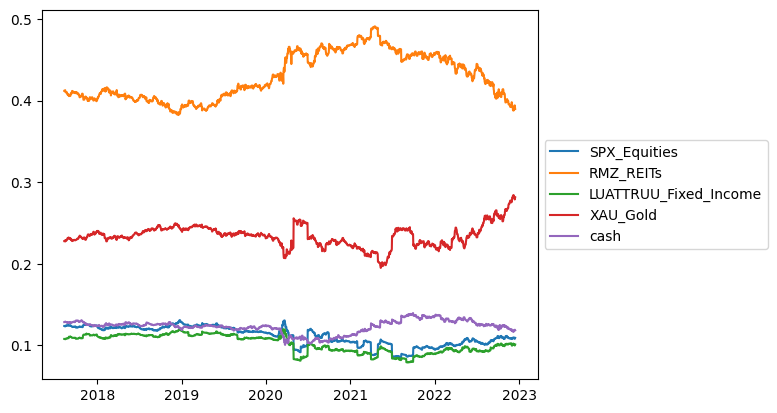

In [5]:
draw_weights(weight_predictions)

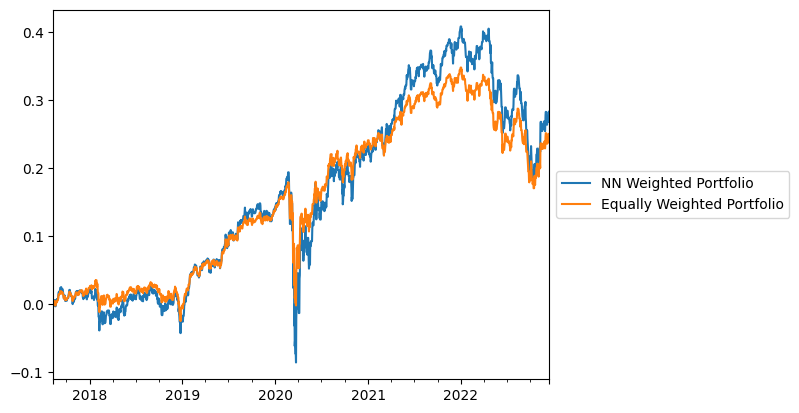

In [6]:
draw_returns(weight_predictions, config.EQUAL)

## export data to csv
---

In [9]:
date_range = pd.date_range(start=weight_predictions.index.min(), end=weight_predictions.index.max(), freq='D')
start_date = date_range[0] - timedelta(days=1)
df_prices = get_indices(start_date.strftime("%Y-%m-%d"), date_range[-1].strftime("%Y-%m-%d")).pct_change().dropna()
return_of_portfolio = (weight_predictions * df_prices).sum(axis=1)
return_of_portfolio = return_of_portfolio.cumsum()
return_of_portfolio.to_csv('export/plot_data.csv', index=False)